In [28]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


# Pytorch device specific configuration
# Pytorch Gpu Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [29]:
# import dataset
iris = pd.read_csv(
    "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv"
)

# convert from pandas dataframe to tensor
data = torch.tensor(iris[iris.columns[0:4]].values).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa'] = 0 # don't need!
labels[iris.species == "versicolor"] = 1
labels[iris.species == "virginica"] = 2

In [30]:
# Break the data into batches
## Use scikitlearn train_test_split to split the data
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2
)

## Convert data into pytorch dataset
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

## Create data loder objects
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    drop_last=True,
    generator=torch.Generator(device),
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_dataset.tensors[0].shape[0],
    shuffle=True,
    generator=torch.Generator(device),
)

In [40]:
# Function to create ANN model
def createNewModel(L2_lambda=0.001, lr=0.005):

    # Model Architecture
    ANNIris = nn.Sequential(
        nn.Linear(4, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 3),
    )

    # Loss Function
    lossFun = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.SGD(ANNIris.parameters(), lr=lr, weight_decay=L2_lambda)

    # Function return statement
    return ANNIris, lossFun, optimizer

In [49]:
# Train the model
def trainTheModel(ANNIris, lossFun, optimizer, nEpochs=5000):

    # Initialize the accuracies and losses as empty array
    trainAcc = []
    testAcc = []
    losses = []

    # For loop over epochs
    for epoch in range(nEpochs):
        # Initialize batchAcc and batchLoss
        batchAcc = []
        batchLoss = []

        # Switch model into train mode
        ANNIris.train()

        # Loop over batches
        for X, y in train_loader:

            # Forward pass
            yHat = ANNIris(X)
            loss = lossFun(yHat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compte batch training accuracy and loss
            batchAcc.append(
                100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).item()
            )
            batchLoss.append(loss.item())

        # Get average training accuracy for this epoch
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))

        # Test accuracy
        ANNIris.eval()  # Model Evaluation mode
        X, y = next(iter(test_loader))  # X, y from test loader dataloader
        predlabels = torch.argmax(ANNIris(X), axis=1)
        testAcc.append(100 * torch.mean((predlabels == y).float()).item())

    # Function return statement
    return trainAcc, testAcc, losses

In [50]:
# Create a model
L2Lambda = 0.01
ANNIris, lossFun, optimizer = createNewModel(L2_lambda=L2Lambda, lr=0.005)

# Train the model
trainAcc, testAcc, losses = trainTheModel(ANNIris, lossFun, optimizer)

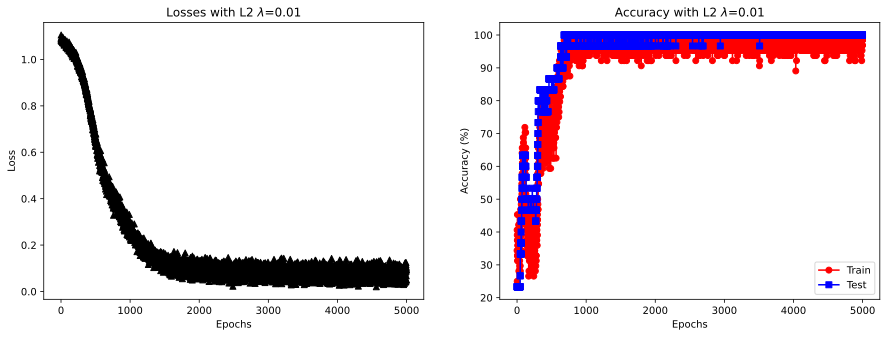

In [51]:
# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(losses, "k^-")
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_title("Losses with L2 $\\lambda$=" + str(L2Lambda))

ax[1].plot(trainAcc, "ro-")
ax[1].plot(testAcc, "bs-")
ax[1].set_title("Accuracy with L2 $\\lambda$=" + str(L2Lambda))
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].legend(["Train", "Test"])

plt.show()

In [52]:
# Create a 1D smoothing filter
def smooth(x, k):
    return np.convolve(x, np.ones(k) / k, mode="same")

## L2 Regularization amount experiment


In [53]:
nEpochs = 5000
# Range of L2 regularization amount
L2Lambdas = np.linspace(0, 0.1, 10)

# Initialize output results matrics
resultAccTrain = np.zeros((nEpochs, len(L2Lambdas)))
resultAccTest = np.zeros((nEpochs, len(L2Lambdas)))

# Loop over L2 regularization amount
for l2i in range(len(L2Lambdas)):

    # Create and train the model
    ANNIris, lossFun, optimizer = createNewModel(L2_lambda=L2Lambdas[l2i])
    trainAcc, testAcc, losses = trainTheModel(ANNIris, lossFun, optimizer, nEpochs)

    # Store the data
    resultAccTrain[:, l2i] = smooth(trainAcc, 10)
    resultAccTest[:, l2i] = smooth(testAcc, 10)

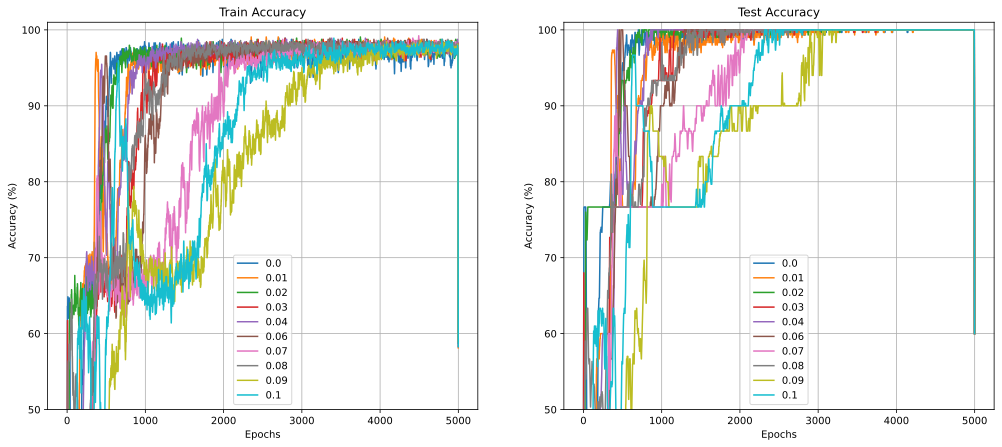

In [54]:
# Plot the experiment results
fig, ax = plt.subplots(1, 2, figsize=(17, 7))

ax[0].plot(resultAccTrain)
ax[0].set_title("Train Accuracy")
ax[1].plot(resultAccTest)
ax[1].set_title("Test Accuracy")

# Make the legends easier to read
leglabels = [np.round(i, 2) for i in L2Lambdas]

# Common Features
for i in range(2):
    ax[i].legend(leglabels)
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel("Accuracy (%)")
    ax[i].set_ylim([50, 101])
    ax[i].grid()

plt.show()

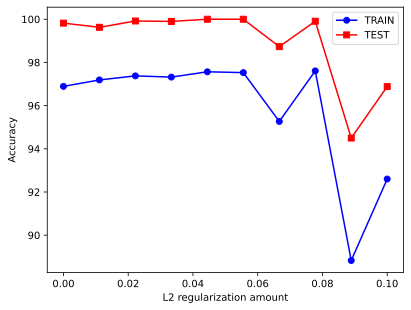

In [57]:
# Show average accuracy by L2 rate

## Average only some epochs
epoch_range = [1500, 4500]

plt.plot(
    L2Lambdas,
    np.mean(resultAccTrain[epoch_range[0] : epoch_range[1], :], axis=0),
    "bo-",
    label="TRAIN",
)
plt.plot(
    L2Lambdas,
    np.mean(resultAccTest[epoch_range[0] : epoch_range[1], :], axis=0),
    "rs-",
    label="TEST",
)
plt.xlabel("L2 regularization amount")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [56]:
# Additional exploration
# # 1) In general, regularization tends to benefit large, complex models, and has less impact (and sometimes even a negative
# #    impact) on smaller or simpler model architectures. Modify the model architecture to have three hidden layers, and
# #    see whether that changes the effect of L2 regularization on performance. (You might want to increase the number of
# #    epochs.)

# # 2) Multiple regularization methods can be combined. Add 15% dropout to the hidden layer(s) and see how that affects
# #    the model's performance.